In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn # Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
from datetime import datetime
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
def load_data():
    try:
        # Update the path to match where you stored your CSV
        df = pd.read_csv('../data/raw_analyst_ratings.csv')  # Adjust path as needed
        print(f"Data loaded successfully with {len(df)} rows and {len(df.columns)} columns")
        return df
    except FileNotFoundError:
        print("File not found. Please check the path to your CSV file.")
        return None

# Load the data
df = load_data()

if df is not None:
    # Display basic information
    print("=== Dataset Overview ===")
    print(f"Shape: {df.shape}")
    print("\n=== Column Names ===")
    print(df.columns.tolist())
    print("\n=== Data Types ===")
    print(df.dtypes)
    print("\n=== First 5 Rows ===")
    display(df.head())
    print("\n=== Missing Values ===")
    print(df.isnull().sum())

Data loaded successfully with 1407328 rows and 6 columns
=== Dataset Overview ===
Shape: (1407328, 6)

=== Column Names ===
['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

=== Data Types ===
Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object

=== First 5 Rows ===


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A



=== Missing Values ===
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64


In [29]:
# 1. Descriptive Statistics
def descriptive_stats(df):
    print("=== DESCRIPTIVE STATISTICS ===")
    
    # Basic info about headlines
    df['headline_length'] = df['headline'].astype(str).apply(len)
    df['word_count'] = df['headline'].astype(str).apply(lambda x: len(x.split()))
    
    print("\n--- Headline Text Statistics ---")
    print(f"Average headline length: {df['headline_length'].mean():.2f} characters")
    print(f"Average word count: {df['word_count'].mean():.2f} words")
    print(f"Shortest headline: {df['headline_length'].min()} characters")
    print(f"Longest headline: {df['headline_length'].max()} characters")
    
    # Articles per publisher
    print("\n--- Articles per Publisher (Top 10) ---")
    publisher_counts = df['publisher'].value_counts().head(10)
    print(publisher_counts)
    
    return df

# 2. Publication Date Analysis
def date_analysis(df):
    print("\n=== PUBLICATION DATE ANALYSIS ===")
    
    # Convert date column to datetime and handle errors
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Check for missing dates
    missing_dates = df['date'].isna().sum()
    if missing_dates > 0:
        print(f"Warning: {missing_dates} rows have missing/invalid dates")
    
    # Extract date components only for valid dates
    valid_dates = df['date'].notna()
    df.loc[valid_dates, 'publication_date'] = df.loc[valid_dates, 'date'].dt.date
    df.loc[valid_dates, 'publication_hour'] = df.loc[valid_dates, 'date'].dt.hour
    df.loc[valid_dates, 'publication_day'] = df.loc[valid_dates, 'date'].dt.day_name()
    df.loc[valid_dates, 'publication_month'] = df.loc[valid_dates, 'date'].dt.month_name()
    
    # Trends over time - only for valid dates
    if valid_dates.any():
        print("--- Publication Frequency Over Time ---")
        daily_counts = df[valid_dates].groupby('publication_date').size()
        
        # Safely get date range
        valid_publication_dates = df.loc[valid_dates, 'publication_date']
        if len(valid_publication_dates) > 0:
            min_date = valid_publication_dates.min()
            max_date = valid_publication_dates.max()
            print(f"Date range: {min_date} to {max_date}")
            print(f"Total days covered: {daily_counts.shape[0]}")
            print(f"Average articles per day: {daily_counts.mean():.2f}")
        else:
            print("No valid dates available for analysis")
    else:
        print("No valid dates found in the dataset")
    
    return df

# 3. Text Analysis
def text_analysis(df):
    print("\n=== TEXT ANALYSIS ===")
    
    # Common keywords in headlines
    all_headlines = ' '.join(df['headline'].astype(str).str.lower())
    words = re.findall(r'\b[a-z]{4,}\b', all_headlines)
    common_words = Counter(words).most_common(20)
    
    print("--- Most Common Words in Headlines ---")
    for word, count in common_words[:10]:
        print(f"{word}: {count}")
    
    # Financial terms to look for
    financial_terms = ['earnings', 'stock', 'price', 'target', 'profit', 'loss', 
                      'quarter', 'growth', 'market', 'share', 'dividend', 'revenue']
    
    print("\n--- Financial Terms Frequency ---")
    for term in financial_terms:
        count = sum(term in headline.lower() for headline in df['headline'].astype(str))
        if count > 0:
            print(f"{term}: {count}")

# 4. Time Series Analysis
def time_series_analysis(df):
    print("\n=== TIME SERIES ANALYSIS ===")
    
    # Publication frequency by hour - only for valid hours
    valid_hours = df['publication_hour'].notna()
    if valid_hours.any():
        print("--- Publication Frequency by Hour ---")
        hourly_counts = df.loc[valid_hours, 'publication_hour'].value_counts().sort_index()
        print(hourly_counts)
    else:
        print("No valid hour data available")
    
    # Publication frequency by day of week - only for valid days
    valid_days = df['publication_day'].notna()
    if valid_days.any():
        print("\n--- Publication Frequency by Day of Week ---")
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_counts = df.loc[valid_days, 'publication_day'].value_counts().reindex(day_order)
        print(daily_counts)
    else:
        print("No valid day data available")
    
    return df

# 5. Publisher Analysis
def publisher_analysis(df):
    print("\n=== PUBLISHER ANALYSIS ===")
    
    # Top publishers
    top_publishers = df['publisher'].value_counts().head(15)
    print("--- Top 15 Publishers ---")
    print(top_publishers)
    
    # Analyze publisher domains if emails are used
    print("\n--- Publisher Email Domains (if applicable) ---")
    email_mask = df['publisher'].str.contains('@', na=False)
    if email_mask.any():
        df['publisher_domain'] = df['publisher'].str.extract(r'@([\w.]+)')
        domain_counts = df['publisher_domain'].value_counts().head(10)
        print(domain_counts)
    else:
        print("No email addresses found in publisher column")
    
    return df

# Run all analyses
def run_complete_eda(df):
    df = descriptive_stats(df)
    df = date_analysis(df)
    text_analysis(df)
    df = time_series_analysis(df)
    df = publisher_analysis(df)
    return df
# Execute the analysis
if df is not None:
    df = run_complete_eda(df)

=== DESCRIPTIVE STATISTICS ===

--- Headline Text Statistics ---
Average headline length: 73.12 characters
Average word count: 11.42 words
Shortest headline: 3 characters
Longest headline: 512 characters

--- Articles per Publisher (Top 10) ---
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64

=== PUBLICATION DATE ANALYSIS ===
--- Publication Frequency Over Time ---
Date range: 2011-04-27 to 2020-06-11
Total days covered: 2528
Average articles per day: 22.15

=== TEXT ANALYSIS ===
--- Most Common Words in Headlines ---
stocks: 161776
from: 120805
market: 120558
shares: 114313
reports: 108710
update: 91723
earnings: 87399
with: 84257
sales: 79645
benzinga: 74516

--- Financial Terms Frequency ---
earnings: 86626
stock: 20286

=== DESCRIPTIVE STATISTICS ===

--- Headline Text Statistics ---
Average headline length: 73.12 characters
Average word count: 11.42 words
Shortest headline: 3 characters
Longest headline: 512 characters

--- Articles per Publisher (Top 10) ---
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64

=== PUBLICATION DATE ANALYSIS ===
--- Publication Frequency Over Time ---
Date range: 2011-04-27 to 2020-06-11
Total days covered: 2528
Average articles per day: 22.15

=== TEXT ANALYSIS ===
--- Most Common Words in Headlines ---
stocks: 161776
from: 120805
market: 120558
shares: 114313
reports: 108710
update: 91723
earnings: 87399
with: 84257
sales: 79645
benzinga: 74516

--- Financial Terms Frequency ---
earnings: 86626
stock: 20286

In [30]:
# Diagnostic function to understand your data structure
def data_diagnostic(df):
    print("=== DATA DIAGNOSTIC ===")
    print(f"Dataset shape: {df.shape}")
    print("\nColumn info:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype} | Missing: {df[col].isna().sum()} ({df[col].isna().sum()/len(df)*100:.2f}%)")
    
    print("\nSample of date column:")
    print(df['date'].head(10))
    
    # Check unique values in key columns
    print(f"\nUnique publishers: {df['publisher'].nunique()}")
    print(f"Unique stocks: {df['stock'].nunique() if 'stock' in df.columns else 'N/A'}")

In [26]:
# Updated Visualization functions with better error handling
def create_visualizations(df):
    print("\n=== CREATING VISUALIZATIONS ===")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Financial News Dataset - Exploratory Data Analysis', fontsize=16)
    
    # 1. Headline length distribution
    axes[0,0].hist(df['headline_length'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_xlabel('Headline Length (characters)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Headline Lengths')
    
    # 2. Top publishers
    top_pubs = df['publisher'].value_counts().head(10)
    axes[0,1].bar(range(len(top_pubs)), top_pubs.values, color='lightcoral')
    axes[0,1].set_xlabel('Publishers')
    axes[0,1].set_ylabel('Number of Articles')
    axes[0,1].set_title('Top 10 Publishers')
    axes[0,1].set_xticks(range(len(top_pubs)))
    axes[0,1].set_xticklabels(top_pubs.index, rotation=45, ha='right')
    
    # 3. Publication by hour (only if we have valid hour data)
    if 'publication_hour' in df.columns:
        valid_hours = df['publication_hour'].notna()
        if valid_hours.any():
            hourly = df.loc[valid_hours, 'publication_hour'].value_counts().sort_index()
            axes[0,2].plot(hourly.index, hourly.values, marker='o', color='green')
            axes[0,2].set_xlabel('Hour of Day')
            axes[0,2].set_ylabel('Number of Articles')
            axes[0,2].set_title('Publication Frequency by Hour')
            axes[0,2].grid(True, alpha=0.3)
        else:
            axes[0,2].text(0.5, 0.5, 'No hour data available', 
                          ha='center', va='center', transform=axes[0,2].transAxes)
            axes[0,2].set_title('Publication Frequency by Hour')
    else:
        axes[0,2].text(0.5, 0.5, 'Hour data not available', 
                      ha='center', va='center', transform=axes[0,2].transAxes)
        axes[0,2].set_title('Publication Frequency by Hour')
    
    # 4. Publication by day of week (only if we have valid day data)
    if 'publication_day' in df.columns:
        valid_days = df['publication_day'].notna()
        if valid_days.any():
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            daily = df.loc[valid_days, 'publication_day'].value_counts().reindex(day_order)
            axes[1,0].bar(daily.index, daily.values, color='orange', alpha=0.7)
            axes[1,0].set_xlabel('Day of Week')
            axes[1,0].set_ylabel('Number of Articles')
            axes[1,0].set_title('Publication Frequency by Day of Week')
            axes[1,0].tick_params(axis='x', rotation=45)
        else:
            axes[1,0].text(0.5, 0.5, 'No day data available', 
                          ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('Publication Frequency by Day of Week')
    else:
        axes[1,0].text(0.5, 0.5, 'Day data not available', 
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Publication Frequency by Day of Week')
    
    # 5. Articles over time (if enough valid data)
    if 'publication_date' in df.columns:
        valid_dates = df['publication_date'].notna()
        if valid_dates.sum() > 10:  # Lowered threshold for smaller datasets
            daily_trend = df.loc[valid_dates].groupby('publication_date').size()
            axes[1,1].plot(daily_trend.index, daily_trend.values, alpha=0.7)
            axes[1,1].set_xlabel('Date')
            axes[1,1].set_ylabel('Articles per Day')
            axes[1,1].set_title('Publication Trend Over Time')
            axes[1,1].tick_params(axis='x', rotation=45)
        else:
            axes[1,1].text(0.5, 0.5, 'Insufficient date data for trend analysis', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Publication Trend Over Time')
    else:
        axes[1,1].text(0.5, 0.5, 'Date data not available', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Publication Trend Over Time')
    
    # 6. Word count distribution
    axes[1,2].hist(df['word_count'], bins=30, alpha=0.7, color='purple')
    axes[1,2].set_xlabel('Word Count')
    axes[1,2].set_ylabel('Frequency')
    axes[1,2].set_title('Distribution of Word Counts')
    
    plt.tight_layout()
    
    # Create images directory if it doesn't exist
    import os
    os.makedirs('../images', exist_ok=True)
    
    plt.savefig('../images/eda_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

=== STARTING TASK 1 EDA ===

1. Running data diagnostic...
=== DATA DIAGNOSTIC ===
Dataset shape: (1407328, 13)

Column info:
Unnamed: 0: int64 | Missing: 0 (0.00%)
headline: object | Missing: 0 (0.00%)
url: object | Missing: 0 (0.00%)
publisher: object | Missing: 0 (0.00%)
date: datetime64[ns, UTC-04:00] | Missing: 1351341 (96.02%)
stock: object | Missing: 0 (0.00%)
headline_length: int64 | Missing: 0 (0.00%)
word_count: int64 | Missing: 0 (0.00%)
publication_date: object | Missing: 1351341 (96.02%)
publication_hour: float64 | Missing: 1351341 (96.02%)
publication_day: object | Missing: 1351341 (96.02%)
publication_month: object | Missing: 1351341 (96.02%)
publisher_domain: object | Missing: 1399240 (99.43%)

Sample of date column:
0   2020-06-05 10:30:54-04:00
1   2020-06-03 10:45:20-04:00
2   2020-05-26 04:30:07-04:00
3   2020-05-22 12:45:06-04:00
4   2020-05-22 11:38:59-04:00
5   2020-05-22 11:23:25-04:00
6   2020-05-22 09:36:20-04:00
7   2020-05-22 09:07:04-04:00
8   2020-05-22 08

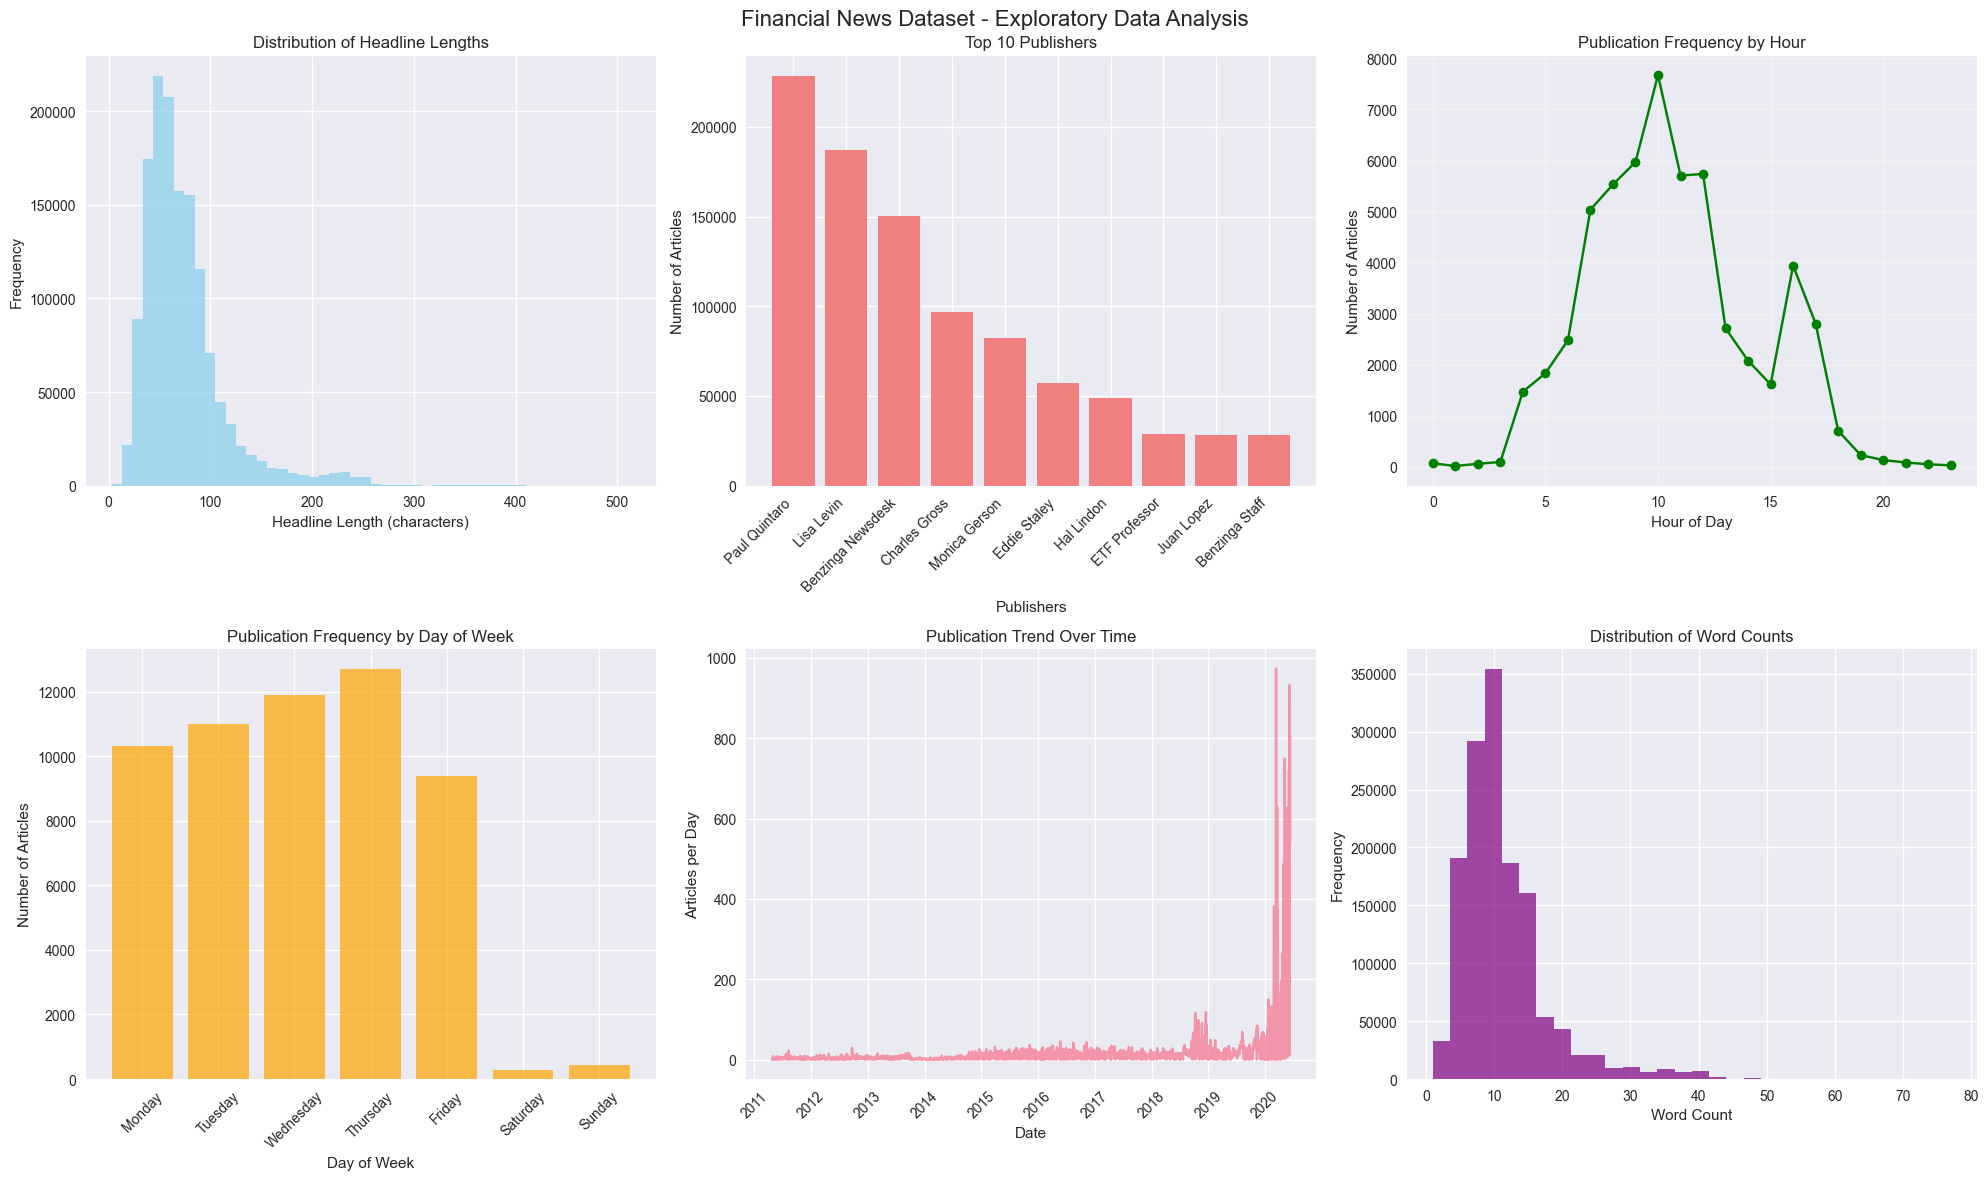


=== TASK 1 EDA COMPLETED SUCCESSFULLY ===


In [27]:
# ===== EXECUTION FLOW =====
# Run everything in the correct order
if df is not None:
    print("=== STARTING TASK 1 EDA ===")
    
    # 1. First run diagnostic
    print("\n1. Running data diagnostic...")
    data_diagnostic(df)
    
    # 2. Then run complete EDA (this creates the new columns)
    print("\n2. Running complete EDA analysis...")
    df = run_complete_eda(df)
    
    # 3. Finally create visualizations
    print("\n3. Creating visualizations...")
    create_visualizations(df)
    
    print("\n=== TASK 1 EDA COMPLETED SUCCESSFULLY ===")
else:
    print("Failed to load data. Please check your file path.")